<a href="https://colab.research.google.com/github/Mineth03/Client-Predicting/blob/Model_Neural_Network/Models/NeuralNetworkModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [352]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [353]:
data = pd.read_csv("BankDataset.csv")

In [354]:
x = data.drop('y', axis=1)
y = data['y']

In [355]:
# Data spliting
XTrain, XTemp, yTrain, yTemp = train_test_split(x, y, test_size=0.2, random_state=42)
# Further spliting
XVal, XTest, yVal, yTest = train_test_split(XTemp, yTemp, test_size=0.5, random_state=42)

In [356]:
smote = SMOTE(
  random_state=42,
  k_neighbors=3,
  sampling_strategy=0.4
)
XTrain, yTrain = smote.fit_resample(XTrain, yTrain)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [357]:
NNmodel = Sequential([
  Dense(256, input_shape=(XTrain.shape[1],), activation='relu'),
  Dropout(0.2),

  Dense(128, activation='relu'),
  Dropout(0.2),

  Dense(64, activation='relu'),
  Dropout(0.2),

  Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [358]:
earlyStop = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)
lrScheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

In [359]:
# Compile
NNmodel.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [360]:
# Train the model
trainingStats = NNmodel.fit(
  XTrain, yTrain,
  validation_data=(XVal, yVal),
  epochs=60,
  batch_size=32,
  verbose=1,
  callbacks=[earlyStop, lrScheduler]
)

Epoch 1/60
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7276 - loss: 0.5409 - val_accuracy: 0.8609 - val_loss: 0.3539 - learning_rate: 1.0000e-04
Epoch 2/60
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8121 - loss: 0.4408 - val_accuracy: 0.8684 - val_loss: 0.3414 - learning_rate: 1.0000e-04
Epoch 3/60
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8214 - loss: 0.4230 - val_accuracy: 0.8711 - val_loss: 0.3388 - learning_rate: 1.0000e-04
Epoch 4/60
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8152 - loss: 0.4266 - val_accuracy: 0.8713 - val_loss: 0.3364 - learning_rate: 1.0000e-04
Epoch 5/60
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8209 - loss: 0.4121 - val_accuracy: 0.8689 - val_loss: 0.3417 - learning_rate: 1.0000e-04
Epoch 6/60
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8265 - loss: 0.4076 - val_accuracy: 0.8703 - val_loss: 0.3387 - learning_rate: 1.0000e-04
Epoch 7/60
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/ste

In [361]:
# Get predictions for the training set
yTrainPred = (NNmodel.predict(XTrain) > 0.5).astype(int)
yTrainActual = yTrain.values
# Get predictions for the testing set
yPred = (NNmodel.predict(XTest) > 0.5).astype(int)

1280/1280 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [362]:
# Training vs Testing accuracy
trainAcc = accuracy_score(yTrainActual, yTrainPred)
testAcc = accuracy_score(yTest, yPred)

In [363]:
print(f"Training Set Accuracy: {trainAcc * 100:.4f}%")
print(f"Testing Set Accuracy: {testAcc * 100:.4f}%")

Training Set Accuracy: 82.7684%
Testing Set Accuracy: 87.6882%


In [364]:
# Classification report for testing set
print("Classification Report :")
print(classification_report(yTest, yPred))

Classification Report (Testing Set):
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      3630
           1       0.48      0.44      0.46       488

    accuracy                           0.88      4118
   macro avg       0.70      0.69      0.69      4118
weighted avg       0.87      0.88      0.87      4118



In [365]:
# ROC-AUC
print(f"ROC-AUC Score : {roc_auc_score(yTest, NNmodel.predict(XTest))}")

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
ROC-AUC Score (Testing Set): 0.7832924061780246


<Figure size 800x600 with 0 Axes>

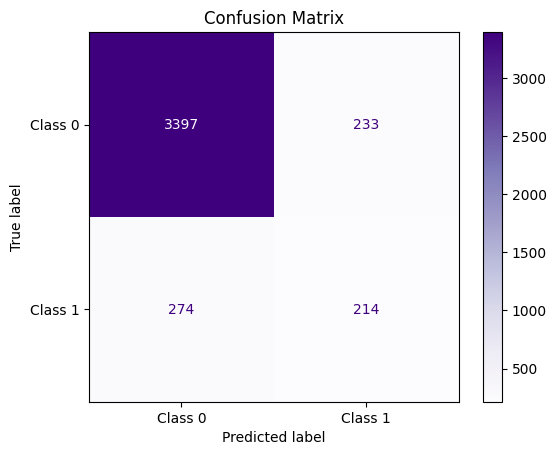

In [366]:
# Confusion matrix
cm = confusion_matrix(yTest, yPred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Purples)
plt.title("Confusion Matrix")
plt.show()